In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier #,Ridge,Lasso,ElasticNet
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,f1_score,confusion_matrix
#from sklearn.model_selection import train_test_split,cross_val_score,KFold,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
import numpy as np
import pyreadstat
from collections import Counter

Opening our DataFrame

In [3]:
df = pd.read_parquet('../../data/interim/fraud_detection.parquet')

In [4]:
df.shape

(307511, 32)

Let's check the overall info of our DataFrame

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

Let's drop KidneyAilments and HeartAilments that are full null column values, and since we do not have any other table to join then we can drop Id

In [6]:
df.drop(columns = ['SK_ID_CURR','AMT_GOODS_PRICE','CODE_GENDER'],inplace = True)

We can see below that it has been dropped

In [7]:
df.sample(3)

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
190849,0,Cash loans,N,Y,0,157500.0,900000.0,38263.5,Children,Commercial associate,...,1,1,0,1,0,0,Laborers,1.0,3,3
187877,0,Cash loans,N,N,0,225000.0,888840.0,29506.5,"Spouse, partner",State servant,...,1,1,0,1,0,0,None,2.0,2,2
128182,0,Revolving loans,Y,N,0,67500.0,270000.0,13500.0,Unaccompanied,Working,...,1,1,0,1,0,0,Sales staff,2.0,2,2


We can check the overall statistics from our dataframe

In [8]:
object_cols = df.select_dtypes(include=['object']).columns

<b> Pipeline Team </b> You should create a function that converts all strings to uppercase

In [9]:
df[object_cols] = df[object_cols].apply(lambda x: x.str.upper())

In [10]:
df.describe(include = 'all')

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
count,307511.000000,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,306219,307511,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,211120,307509.000000,307511.000000,307511.000000
unique,NaN,2,2,2,NaN,NaN,NaN,NaN,7,8,...,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN
top,NaN,CASH LOANS,N,Y,NaN,NaN,NaN,NaN,UNACCOMPANIED,WORKING,...,NaN,NaN,NaN,NaN,NaN,NaN,LABORERS,NaN,NaN,NaN
freq,NaN,278232,202924,213312,NaN,NaN,NaN,NaN,248526,158774,...,NaN,NaN,NaN,NaN,NaN,NaN,55186,NaN,NaN,NaN
mean,0.080729,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,NaN,NaN,...,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,NaN,2.152665,2.052463,2.031521
std,0.272419,NaN,NaN,NaN,0.722121,2.371231e+05,4.024908e+05,14493.737315,NaN,NaN,...,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,NaN,0.910682,0.509034,0.502737
min,0.000000,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000
25%,0.000000,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16524.000000,NaN,NaN,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,2.000000,2.000000,2.000000
50%,0.000000,NaN,NaN,NaN,0.000000,1.471500e+05,5.135310e+05,24903.000000,NaN,NaN,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN,2.000000,2.000000,2.000000
75%,0.000000,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,NaN,NaN,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,NaN,3.000000,2.000000,2.000000


In [11]:
if (df['AMT_ANNUITY'].dtypes == 'int64') | (df['AMT_ANNUITY'].dtypes == 'float64'):
    print('x')

x


<b> Pipeline Team </b> Example of pipeline function

In [12]:
def drop_high_nulls_col(df):
    # Grouped median calculation for filling missing values
    
    for cols in df.columns:
        if (df[cols].notnull().sum() / df.shape[0]) < 0.4:
            df.drop(columns=[cols], inplace=True)
            
    return df

In [13]:
df = drop_high_nulls_col(df)

Let's understand FacilityId better, because if there is lot's of facility id's then we can also drop this column

In [14]:
df.shape[0]

307511

### Feature Engineering

In [15]:
X_col = df.drop(columns = 'TARGET').columns
y_col = ['TARGET']

We are doing a 80-20 Train,Test split we will be locking the random_state as 37 so our results are easy to produce again

In [16]:
group_cols = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

In [17]:
X_train,X_test,y_train,y_test = train_test_split(df[X_col],df[y_col],stratify=df[group_cols],train_size=0.8,test_size = 0.2,random_state=37)

In [18]:
X_train.to_parquet('../data/processed/X_train.parquet',index=False)
X_test.to_parquet('../data/processed/X_test.parquet',index=False)
y_train.to_parquet('../data/processed/y_train.parquet',index=False)
y_test.to_parquet('../data/processed/y_test.parquet',index=False)

OSError: Cannot save file into a non-existent directory: '..\data\processed'

Now to start feature engineering let's check our null values one more time

<b> Pipeline Team </b> Example of pipeline function

In [19]:
def null_dict(df,grouped_cols):
    imputation_dict = {}
    # Calculate the sum of null values for each column
    null_sum = df.isnull().sum()

    # Filter columns where the sum of null values is greater than 0
    columns_with_nulls = null_sum[null_sum > 0].index

    # Select only the columns from the original DataFrame that have more than 0 null values
    null_cols = df.loc[:, columns_with_nulls].columns
    for col in null_cols:
        if (df[col].dtypes == 'int64') | (df[col].dtypes == 'float64'):
            imputation_dict.update({col : df.groupby(grouped_cols)[col].median().to_dict()})
        elif (df[col].dtypes == 'O'):
            imputation_dict.update({col : df.groupby(grouped_cols)[col].agg(pd.Series.mode).to_dict()})
                
    return imputation_dict

Lets go ahead and imput the values on the DF

In [20]:
imput_dict = null_dict(X_train,group_cols)

<b> Pipeline Team </b> Example of pipeline function

In [21]:
def fillnulls(data,grouped_cols,imput_dict):
    imputation_dict = imput_dict
    
    col_x,col_y,col_z =grouped_cols
    
    for col in imputation_dict:
        for val in imputation_dict[col]:
            val_x,val_y,val_z = val
            data.loc[(data[col_x] == val_x) & (data[col_z] == val_z) & (data[col_z] == val_z),col] = imputation_dict[col][val]
    return data

In [22]:
X_train = fillnulls(X_train,group_cols,imput_dict)
X_test = fillnulls(X_test,group_cols,imput_dict)

<b> Pipeline Team </b> You should create a function to do one hotting and one to convert it back

In [23]:
object_cols = df.select_dtypes(include=['object']).columns

In [24]:
oneh = OneHotEncoder(sparse_output=False)
oneh.fit(X_train[object_cols])

OneHotEncoder(sparse_output=False)

In [25]:
col_names = oneh.get_feature_names_out()

In [26]:
X_train_dummies = pd.DataFrame(oneh.transform(X_train[object_cols]),columns = col_names)
X_train_dummies.index = X_train.index
X_train = pd.merge(X_train,X_train_dummies,left_index=True,right_index=True)

X_test_dummies = pd.DataFrame(oneh.transform(X_test[object_cols]),columns = col_names)
X_test_dummies.index = X_test.index
X_test = pd.merge(X_test,X_test_dummies,left_index=True,right_index=True)

In [27]:
X_train.sample(3)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,NAME_FAMILY_STATUS_SINGLE / NOT MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,NAME_HOUSING_TYPE_CO-OP APARTMENT,NAME_HOUSING_TYPE_HOUSE / APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL APARTMENT,NAME_HOUSING_TYPE_OFFICE APARTMENT,NAME_HOUSING_TYPE_RENTED APARTMENT,NAME_HOUSING_TYPE_WITH PARENTS,OCCUPATION_TYPE_LABORERS
78819,CASH LOANS,N,Y,0,180000.0,754740.0,29385.0,UNACCOMPANIED,WORKING,SECONDARY / SECONDARY SPECIAL,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
151172,CASH LOANS,N,N,1,94500.0,1546020.0,28116.0,UNACCOMPANIED,WORKING,HIGHER EDUCATION,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
294426,CASH LOANS,N,N,0,148500.0,1128415.5,28116.0,UNACCOMPANIED,WORKING,SECONDARY / SECONDARY SPECIAL,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


All that's left is to drop Gender

In [28]:
X_train.drop(columns = object_cols,inplace = True)
X_test.drop(columns = object_cols,inplace = True)

We will now transform balance this data

<b> Pipeline Team </b> Create a function that combines the three techniques and outpus X_train, y_train midsampled, check below for what you should expect

In [29]:
def oversample_with_adasyn(X, y, target_minority_samples=180000):
    """
    Oversample the minority class using ADASYN until the minority class reaches the target_minority_samples.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    - target_minority_samples: Desired number of samples for the minority class after oversampling
    
    Returns:
    - X_resampled, y_resampled: Feature matrix and target vector after resampling
    """
    # Identify minority class
    classes, counts = np.unique(y, return_counts=True)
    minority_class = classes[np.argmin(counts)]
    current_minority_samples = counts[np.argmin(counts)]

    # Calculate how many new samples we need to generate for the minority class
    if current_minority_samples >= target_minority_samples:
        raise ValueError("The minority class already has more or equal samples than the target_minority_samples.")
    
    n_samples_to_generate = target_minority_samples - current_minority_samples

    # Set the sampling strategy for ADASYN
    # This will tell ADASYN to generate the specified number of samples for the minority class
    sampling_strategy = {minority_class: n_samples_to_generate}

    # Create the ADASYN instance and fit it to the data
    adasyn = ADASYN(sampling_strategy=sampling_strategy, n_neighbors=5, random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X, y)

    return X_resampled, y_resampled

In [30]:
def undersample_with_nearmiss(X, y):
    """
    Undersample the majority class using NearMiss until it is balanced with the minority class.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    
    Returns:
    - X_resampled, y_resampled: Feature matrix and target vector after resampling
    """
    # Identify majority and minority classes
    classes, counts = np.unique(y, return_counts=True)
    minority_class_count = min(counts)
    
    # Set the sampling strategy for NearMiss
    # This will balance the majority class with the minority class
    nm = NearMiss()
    
    # Perform the undersampling
    X_resampled, y_resampled = nm.fit_resample(X, y)
    
    # Check if undersampling was successful
    if len(np.unique(y_resampled, return_counts=True)[1]) != 2 or np.unique(y_resampled, return_counts=True)[1][0] != minority_class_count:
        raise ValueError("NearMiss did not undersample correctly.")
    
    return X_resampled, y_resampled

In [31]:
X_resampled,y_resampled = oversample_with_adasyn(X_train,y_train)

In [32]:
X_train,y_train = undersample_with_nearmiss(X_resampled,y_resampled)

In [33]:
X_train.to_parquet('../data/processed/X_train_engineered.parquet',index=False)
X_test.to_parquet('../data/processed/X_test_engineered.parquet',index=False)
y_train.to_parquet('../data/processed/y_train_engineered.parquet',index=False)
y_test.to_parquet('../data/processed/y_test_engineered.parquet',index=False)

OSError: Cannot save file into a non-existent directory: '..\data\processed'

In [34]:
y_train.groupby(['TARGET']).size()

TARGET
0    161378
1    161378
dtype: int64

Scaling

<b> Pipeline Team </b> Create a function to scale and one to de-scale variables.

In [35]:
scaler = StandardScaler()

In [36]:
scaler.fit(X_train)

StandardScaler()

In [37]:
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [38]:
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

### Machine Learning

M.L. Team:
- You should work on not overfitting and having a feasible model. <b> You can only use Logistic Regression/Ridge/Lasso </b>
- Think correctly on the error metric, remember that we want to have a model that predicts very well FRAUD so we can penalize False Positives
- Use my overfitted scores and try to beat them, and it is as simple as having a feasible model, after that you start to improve.

<b>LinearRegression<b>

C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kiran\AppData\Roaming\Python\Python311\site-pac

Accuracy of training is 0.673239227156118
Precision of training is 0.6536554801974213
Recall of training is 0.7369653856163789
F1 of training is 0.6928149503093288
ROC AUC of training is 0.673239227156118

Accuracy of test is 0.6007349234996667
Precision of test is 0.0902621722846442
Recall of test is 0.4459292763157895
F1 of test is 0.1501349761196096
ROC AUC of test is 0.5299792394043856


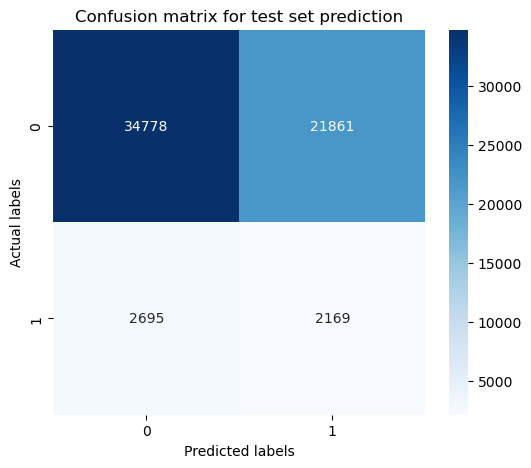

In [44]:
# Starting Linear Regression
logr = LogisticRegression(solver='lbfgs',max_iter=500)

#Define grid of hyperparameters
parameter = {'logisticregression__C':[0.01,0.1,1,10],'logisticregression__penalty':['l1','l2']}

pipeline = make_pipeline(StandardScaler(),logr)

random_search = RandomizedSearchCV(estimator=pipeline,param_distributions=parameter,cv=3,scoring='precision',n_jobs=-1,n_iter=5,random_state=42)

#subset = len(X_train) // 10
#Fitting Linear Regression
random_search.fit(X_train,y_train)

check_params = random_search.best_params_
check_model = random_search.best_estimator_

#Predicting the test data
y_train_predict = check_model.predict(X_train)
y_predict = check_model.predict(X_test)


#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,y_train_predict)))
print('Precision of training is '+ str(precision_score(y_train,y_train_predict)))
print('Recall of training is '+ str(recall_score(y_train,y_train_predict)))
print('F1 of training is '+ str(f1_score(y_train,y_train_predict)))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,y_train_predict)))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,y_predict)))
print('Precision of test is '+ str(precision_score(y_test,y_predict)))
print('Recall of test is '+ str(recall_score(y_test,y_predict)))
print('F1 of test is '+ str(f1_score(y_test,y_predict)))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,y_predict)))


#Computing confusion matrix for the test set prediction
Confusion_matrix_test = confusion_matrix(y_test,y_predict)

#plotting the confusion matrix for the test set prediction
plt.figure(figsize=(6,5))
sns.heatmap(Confusion_matrix_test,annot=True,fmt='g',cmap='Blues',cbar=True)
plt.title('Confusion matrix for test set prediction')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()


It's an okay start for a LinearRegression, Train vs Test is not Overfitting which is good.
Let's follow with the other models

In [40]:
# Starting Ridge
logr = RidgeClassifier(alpha=3)

#Fitting
logr.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test))))

C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_ridge.py:1223: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of training is 0.6726846286358735
Precision of training is 0.649538251849944
Recall of training is 0.7500774578938889
F1 of training is 0.6961968165413318
ROC AUC of training is 0.6726846286358734

Accuracy of test is 0.5972716778043348
Precision of test is 0.09179278946720808
Recall of test is 0.46011513157894735
F1 of test is 0.15305180372713284
ROC AUC of test is 0.5345827163041367


Ridge works just like LR, since there is not much complexity to the model it looks okay

<b>XGBoost<b>

In [41]:
# Starting XGBoost
logr = XGBClassifier(n_estimators = 1000,learning_rate = 0.01,eval_metric='aucpr')

#Fitting
logr.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test))))

Accuracy of training is 0.9210115381278737
Precision of training is 0.9998087335216572
Recall of training is 0.8421841886750363
F1 of training is 0.9142522720087181
ROC AUC of training is 0.9210115381278737

Accuracy of test is 0.9141180105035527
Precision of test is 0.04956896551724138
Recall of test is 0.0047286184210526315
F1 of test is 0.008633633633633633
ROC AUC of test is 0.4984712320022423


XGBoost has proven to be the best so far, let's check for LGBM and then we can do a hyperparameter tuning

<b>LightGBM<b>

In [42]:
# Starting XGBoost
logr = LGBMClassifier(n_estimators = 1000,learning_rate = 0.01)

#Fitting
logr.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test))))

C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161378, number of negative: 161378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8019
[LightGBM] [Info] Number of data points in the train set: 322756, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy of training is 0.9299997521347395
Precision of training is 0.9996040174232333
Recall of training is 0.8603403190025902
F1 of training is 0.9247584697924889
ROC AUC of training is 0.9299997521347395

Accuracy of test is 0.9128497796855438
Precision of test is 0.06491228070175438
Recall of test is 0.007606907894736842
F1 of test is 0.013617960986382039
ROC AUC of test is 0.4990982155074243


The result of LGBM is just like XGBoost, let's try hyper parameter tuning on XGBoost to see if we can improve model performance.